# Automotive industry sites

In [1]:
import geopandas
import pandas as pd
import numpy as np
import pyproj
from shapely.ops import transform

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib, descartes
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

from pynsee import *

In [2]:
# get activity list
naf5 = get_activity_list('NAF5')

# search data in SIRENE database
data = search_sirene(variable = "activitePrincipaleEtablissement",
                   pattern = '29.10Z', kind = 'siret', number=2000)

Existing environment variables used, instead of locally saved credentials
2/2 - Getting data: 100%|██████████| 176/176 [00:00<00:00, 237.86it/s]
This function may return personal data, please check and comply with the legal framework relating to personal data protection !


In [3]:
# keep only businesses with more then 100 employees
df = data.loc[data['effectifsMinEtablissement'] > 100]
df = df.reset_index(drop=True)
# find latitude and longitude of all businesses
df = df.get_location()

Getting location: 100%|██████████| 51/51 [00:34<00:00,  1.50it/s]


In [4]:
df.head(2)

,siren,nic,siret,dateDebut,dateCreationEtablissement,dateCreationUniteLegale,dateFin,denominationUniteLegale,nomUniteLegale,prenomUsuelUniteLegale,...,libelleCommuneEtranger2Etablissement,codePaysEtranger2Etablissement,libellePaysEtranger2Etablissement,latitude,longitude,category,crsCoord,type,importance,geometry
0,006580195,00011,00658019500011,2008-01-01,1965-01-01,1965-01-01,None,SOCIETE INDUSTRIELLE POUR LE DEVELOPPEMENT DE ...,None,None,...,None,None,None,47.290836,-2.194644,highway,EPSG:4326,residential,0.81001,POINT (-2.1946435 47.2908359)
1,302279229,00025,30227922900025,2014-07-25,1900-01-01,1975-01-01,None,RAPIDO,None,None,...,None,None,None,48.308759,-0.642728,place,EPSG:4326,house,0.72010,POINT (-0.6427279 48.308759)


In [6]:
# make geodataframe
gdf = geopandas.GeoDataFrame(df)
gdf = gdf.reset_index(drop=True)
gdf = gdf.sort_values(by=['effectifsMinEtablissement'], ascending=False)

In [7]:
# get map - departement limits
geodataList =  get_geodata_list()
mapdep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
mapdep = mapdep.translate()

# conversion to geopandas df
mapdepgeo = geopandas.GeoDataFrame(mapdep)
mapdepgeo.head()

,id,nom_m,nom,insee_dep,insee_reg,geometry,bbox,crsCoord
0,DEPARTEM_GLP_00000000001,GUADELOUPE,Guadeloupe,971,01,"MULTIPOLYGON (((-739144.768 6296095.811, -7391...","[-6880639.76094451, 1785277.73400778, -6790707...",EPSG:3857
1,DEPARTEM_MTQ_00000000001,MARTINIQUE,Martinique,972,02,"MULTIPOLYGON (((-756752.387 6056818.795, -7567...","[-6815985.71107846, 1618842.96967012, -6769303...",EPSG:3857
2,DEPARTEM_REU_00000000001,LA REUNION,La Réunion,974,04,"MULTIPOLYGON (((-807376.954 5867965.281, -8072...","[6146672.336885, -2438398.99690376, 6215705.13...",EPSG:3857
3,DEPARTEM_GUF_00000000001,GUYANE,Guyane,973,03,"MULTIPOLYGON (((-650783.613 5681770.336, -6507...","[-6078310.30343627, 235055.06017674, -5746205....",EPSG:3857
4,DEPARTEM_MYT_00000000001,MAYOTTE,Mayotte,976,06,"MULTIPOLYGON (((-553726.624 5453062.725, -5537...","[5011418.77897208, -1460351.156634, 5042772.00...",EPSG:3857


In [8]:
# make cleaned labels
match_list = ['RENAULT SAS', 'ALPINE', 'BATILLY', 'MAUBEUGE CONSTRUCTION',
              'TOYOTA', 'PSA AUTOMOBILES', 'VEHICULES LEGERS DU NORD', 'RENAULT TRUCKS']
other_string_list = '|'.join(['[^' + x + ']' for x in match_list])

conditions = [gdf['denominationUniteLegale'].str.contains(x) for x in match_list]
conditions += [gdf['denominationUniteLegale'].str.contains(other_string_list)]

values = ['RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS',
          'TOYOTA', 'PSA AUTOMOBILES','PSA AUTOMOBILES', 'RENAULT TRUCKS', 'OTHER']

gdf['label'] = np.select(conditions, values)

In [9]:
def _convert_polygon(geo, crs_in='EPSG:4326', crs_out='EPSG:3857'):

    if geo is not None:
        crsIn = pyproj.CRS(crs_in)
        crsOut = pyproj.CRS(crs_out)

        project = pyproj.Transformer.from_crs(crsIn, crsOut, always_xy=True).transform
        geo_converted = transform(project, geo)

        return geo_converted

# convert openstreetmap data from crs 4326 to crs 3857
gdf['geometry'] = gdf['geometry'].apply(lambda x: _convert_polygon(x))

gdf["crs"] = 'EPSG:3857'

In [15]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

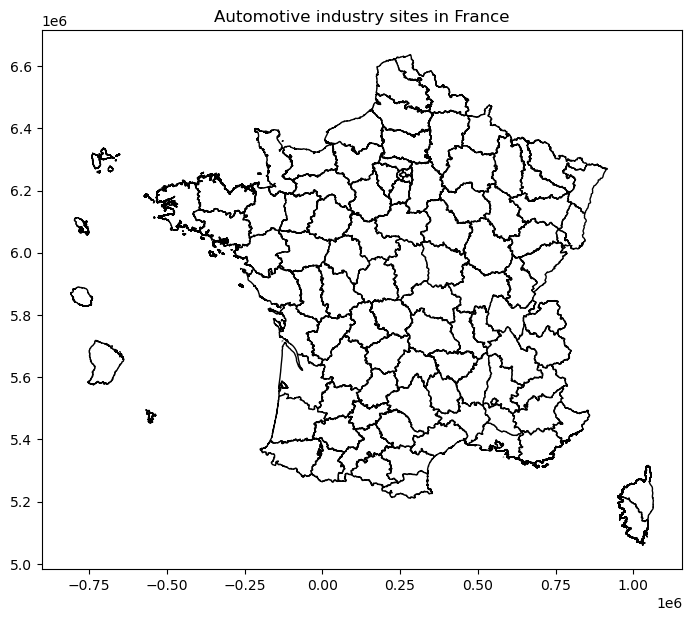

In [10]:
# annotation
txt = 'Circles are proportionate to the minimum of the employee number range'
txt += '\nIf headcount is missing in SIRENE database, some factories may not be displayed'

#plot
ax = mapdepgeo.plot(color='white', edgecolor='black', figsize = (15,7))
plt.title('Automotive industry sites in France')
gdf.plot(ax=ax,
         column = 'label',
         edgecolor='white',
         markersize=gdf.effectifsMinEtablissement/5,
         legend=True,
         legend_kwds={'bbox_to_anchor': (1.1,1),
                       'loc':1, 'borderaxespad': 0})

at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc='lower left')
ax.add_artist(at)
ax.set_axis_off()
plt.show()

In [ ]:
gdf.rename(columns={'siren' : 'SIREN'})